In [1]:
# === Step 1: Imports and setup ===
import os
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.optimize import brentq

# Output folders
output_common = Path("output_common"); output_common.mkdir(exist_ok=True)
output_speed = Path("output_speed_based"); output_speed.mkdir(exist_ok=True)
output_other = Path("output_other_features"); output_other.mkdir(exist_ok=True)


In [2]:
# === Step 2: Load & clean data ===
df = pd.read_csv("main dataset.csv")
df = df.dropna(subset=["crash_rate_per_km"])
osm_ids = df["osm_id"]
df = df.drop(columns=["city", "osm_id", "name"])

In [3]:
# === Step 3: Bin rare surface types ===
threshold = 5
df["surface"] = df["surface"].where(df["surface"].map(df["surface"].value_counts()) >= threshold, "other")

In [4]:
# === 4. Feature engineering ===
# Interaction terms
df['aadt_curv_interaction'] = df['aadt'] * df['mean_curvature']
df['aadt_lanes_interaction'] = df['aadt'] * df['lanes']
df['aadt_length_interaction'] = df['aadt'] * df['segment_length_km']
df['aadt_speed'] = df['aadt'] * df['maxspeed']
df['aadt_pop_interaction'] = df['aadt'] * df['population']
df['lanes_length_interaction'] = df['lanes'] * df['segment_length_km']
df['lanes_speed_interaction'] = df['lanes'] * df['maxspeed']
df['curv_lanes_interaction'] = df['mean_curvature'] * df['lanes']

# Polynomial/nonlinear terms
df['maxspeed_sq'] = df['maxspeed'] ** 2
df['mean_curvature_sq'] = df['mean_curvature'] ** 2
df['aadt_sq'] = df['aadt'] ** 2
df['lanes_sq'] = df['lanes'] ** 2
df['segment_length_sq'] = df['segment_length_km'] ** 2

# Ratios/densities (protect against divide-by-zero)
df['aadt_per_lane'] = df['aadt'] / df['lanes'].replace(0, np.nan)
df['pop_density_per_length'] = df['population'] / df['segment_length_km'].replace(0, np.nan)
df['aadt_per_length'] = df['aadt'] / df['segment_length_km'].replace(0, np.nan)
df['crashes_per_pop'] = df['city_total_crashes'] / df['population'].replace(0, np.nan)
df['crashes_per_aadt'] = df['city_total_crashes'] / df['aadt'].replace(0, np.nan)

# Binary/categorical combinations (example: adjust according to your categories)
df['urban'] = (df['classification'].str.lower().str.contains('urban')).astype(int)
df['urban_high_aadt'] = ((df['urban'] == 1) & (df['aadt'] > df['aadt'].median())).astype(int)
df['bridge_high_speed'] = ((df['bridge'] == 1) & (df['maxspeed'] > df['maxspeed'].median())).astype(int)
df['tunnel_high_speed'] = ((df['tunnel'] == 1) & (df['maxspeed'] > df['maxspeed'].median())).astype(int)

# If you have 'sidewalk' and 'oneway' as binary
df['sidewalk_high_pop'] = ((df['sidewalk'] == 1) & (df['population'] > df['population'].median())).astype(int)
df['oneway_high_speed'] = ((df['oneway'] == 1) & (df['maxspeed'] > df['maxspeed'].median())).astype(int)

def attach_ids(df_part, ids):
    df_part = df_part.reset_index(drop=True)
    df_part['osm_id'] = ids.reset_index(drop=True)
    return df_part

# Display only the engineered features
engineered_features = [
    'aadt_curv_interaction', 'aadt_lanes_interaction', 'aadt_length_interaction',
    'aadt_speed', 'aadt_pop_interaction', 'lanes_length_interaction',
    'lanes_speed_interaction', 'curv_lanes_interaction',
    'maxspeed_sq', 'mean_curvature_sq', 'aadt_sq', 'lanes_sq', 'segment_length_sq',
    'aadt_per_lane', 'pop_density_per_length', 'aadt_per_length',
    'crashes_per_pop', 'crashes_per_aadt',
    'urban', 'urban_high_aadt', 'bridge_high_speed', 'tunnel_high_speed',
    'sidewalk_high_pop', 'oneway_high_speed'
]

df[engineered_features]

,aadt_curv_interaction,aadt_lanes_interaction,aadt_length_interaction,aadt_speed,aadt_pop_interaction,lanes_length_interaction,lanes_speed_interaction,curv_lanes_interaction,maxspeed_sq,mean_curvature_sq,...,pop_density_per_length,aadt_per_length,crashes_per_pop,crashes_per_aadt,urban,urban_high_aadt,bridge_high_speed,tunnel_high_speed,sidewalk_high_pop,oneway_high_speed
0,0.160035,79422,8577.014852,794220,35239501689,0.431972,40,0.000008,400,1.624090e-11,...,4.108597e+06,1.838593e+05,0.000042,0.000932,1,1,0,0,0,0
1,1486.544898,121466,2754.776812,2429320,53894403467,0.090718,80,0.048953,1600,5.991100e-04,...,1.956398e+07,1.338946e+06,0.000042,0.000609,1,1,0,0,0,0
2,276.784835,56520,1854.321965,1130400,25077895740,0.131233,80,0.019588,1600,9.592687e-05,...,1.352402e+07,4.306844e+05,0.000042,0.001309,1,1,0,0,0,0
3,410.937645,59634,3474.233468,1192680,26459575983,0.233037,80,0.027564,1600,1.899433e-04,...,7.615946e+06,2.558992e+05,0.000042,0.001241,1,1,0,0,0,0
4,23.294309,47892,4246.341074,957840,21249656454,0.354660,80,0.001946,1600,9.463106e-07,...,5.004227e+06,1.350365e+05,0.000042,0.001545,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456,22.465230,16390,14580.087186,327800,8008432630,3.558289,80,0.005483,1600,7.514911e-06,...,5.492719e+05,4.606147e+03,0.000122,0.014521,1,0,0,0,0,0
5457,19.969008,7484,15475.558114,149680,3656809628,8.271276,80,0.010673,1600,2.847773e-05,...,2.362958e+05,9.048180e+02,0.000122,0.031801,1,0,0,0,0,0
5458,24.989836,26088,35960.227782,782640,12747040296,5.513681,120,0.003832,3600,3.670331e-06,...,3.544761e+05,4.731503e+03,0.000122,0.009123,1,1,1,0,0,1
5459,245.098624,10274,639.420747,410960,5020051058,0.248947,160,0.095425,6400,2.276474e-03,...,7.850936e+06,4.126980e+04,0.000122,0.023165,1,0,0,0,0,0


In [5]:
# === 5. Train/test split ===
y_rate = df['crash_rate_per_km']
y_crashes = df['city_total_crashes']
X = df.drop(columns=['crash_rate_per_km','city_total_crashes','segment_length'])
a,b,c,d,e,f,g,h = train_test_split(
    X, y_rate, y_crashes, osm_ids,
    test_size=0.2, stratify=X['highway'], random_state=42
)
X_train, X_test, y_tr_rate, y_te_rate, y_tr_crash, y_te_crash, osm_tr, osm_te = (a,b,c,d,e,f,g,h)
X_train = attach_ids(X_train, osm_tr)
X_test = attach_ids(X_test, osm_te)
for y in [y_tr_rate, y_tr_crash, y_te_rate, y_te_crash]: y.reset_index(drop=True, inplace=True)

# observed speed bounds
s_min, s_max = df['maxspeed'].min(), df['maxspeed'].max()

In [6]:
# === 6. Preprocessing pipeline (minimal, robust against collinearity) ===

binary_cols = ['bridge', 'tunnel', 'lit', 'sidewalk', 'oneway', 'cycleway']

numeric_cols = [
    # Base features
    'lanes',
    'maxspeed',
    'segment_width',
    'mean_curvature',
    'aadt',
    'population',
    'segment_length_km',

  
    'aadt_curv_interaction',     
    'aadt_per_lane',              

    # Binary columns (as numeric)
    'bridge',
    'tunnel',
    'lit',
    'sidewalk',
    'oneway',
    'cycleway',
    'urban'
]
pre = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ['surface', 'highway', 'classification'])
], remainder='drop')

X_tr_p = pre.fit_transform(X_train)
X_te_p = pre.transform(X_test)
feat_names = np.concatenate([
    pre.named_transformers_['num'].get_feature_names_out(numeric_cols),
    pre.named_transformers_['cat'].get_feature_names_out(['surface', 'highway', 'classification'])
])

X_tr_df = pd.DataFrame(X_tr_p[:, :len(numeric_cols)], columns=numeric_cols)
print("Correlation matrix for numeric features:")
X_tr_df.corr()

Correlation matrix for numeric features:


,lanes,maxspeed,segment_width,mean_curvature,aadt,population,segment_length_km,aadt_curv_interaction,aadt_per_lane,bridge,tunnel,lit,sidewalk,oneway,cycleway,urban
lanes,1.000000,0.110883,0.098128,-0.067959,-0.002252,-0.002442,0.062547,-0.046075,-0.210182,0.080703,-0.000672,0.172509,0.182166,0.127832,0.135148,-0.025271
maxspeed,0.110883,1.000000,-0.073075,-0.029008,0.079794,0.003585,0.298931,0.026141,0.049302,0.285781,0.032416,-0.146218,-0.053765,0.015977,-0.062007,0.018653
segment_width,0.098128,-0.073075,1.000000,0.184330,-0.015605,-0.010366,-0.006342,0.121684,-0.013479,0.252745,0.142991,0.244470,0.231738,0.302413,0.153505,0.036402
mean_curvature,-0.067959,-0.029008,0.184330,1.000000,0.008462,0.026646,-0.046662,0.737683,0.023727,-0.086118,-0.026600,-0.047853,-0.056890,0.054948,-0.025783,0.032768
aadt,-0.002252,0.079794,-0.015605,0.008462,1.000000,-0.025300,-0.000701,0.330967,0.945484,-0.003734,-0.012024,-0.166821,-0.136599,-0.023260,0.014726,0.037465
population,-0.002442,0.003585,-0.010366,0.026646,-0.025300,1.000000,-0.009864,0.013254,-0.037382,-0.027161,0.004151,0.093243,0.156732,-0.021208,0.004448,0.431196
segment_length_km,0.062547,0.298931,-0.006342,-0.046662,-0.000701,-0.009864,1.000000,-0.025309,-0.011564,0.384213,0.070799,-0.017948,0.111701,0.090839,0.026265,-0.046974
aadt_curv_interaction,-0.046075,0.026141,0.121684,0.737683,0.330967,0.013254,-0.025309,1.000000,0.332552,-0.054721,-0.018787,-0.085426,-0.079292,0.036805,-0.021341,0.034449
aadt_per_lane,-0.210182,0.049302,-0.013479,0.023727,0.945484,-0.037382,-0.011564,0.332552,1.000000,-0.012335,0.000929,-0.174265,-0.154836,-0.018300,0.007509,0.047635
bridge,0.080703,0.285781,0.252745,-0.086118,-0.003734,-0.027161,0.384213,-0.054721,-0.012335,1.000000,0.055049,0.024325,0.200011,0.122667,0.056822,-0.006491


=== VIF Results ===
                  feature        VIF
0                   lanes   1.934009
1                maxspeed   1.652624
2           segment_width   1.340985
3          mean_curvature   2.675316
4                    aadt  15.962424
5              population   1.297833
6       segment_length_km   1.349252
7   aadt_curv_interaction   2.879208
8           aadt_per_lane  16.645696
9                  bridge   1.440572
10                 tunnel   1.038581
11                    lit   1.986707
12               sidewalk   1.933096
13                 oneway   1.276957
14               cycleway   1.118728
15                  urban   3.384958
16       surface_concrete   1.651244
17         surface_gravel   1.031115
18          surface_metal   1.047094
19          surface_other   1.019196
20          surface_paved   1.342507
21        surface_unpaved   1.277826
22      highway_secondary   2.753482
23       highway_tertiary   4.143030
24          highway_trunk   1.375950
25   classificatio

C:\Users\joaqu\AppData\Local\Temp\ipykernel_18948\3462720362.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_sorted, x='VIF', y='feature', palette='magma')


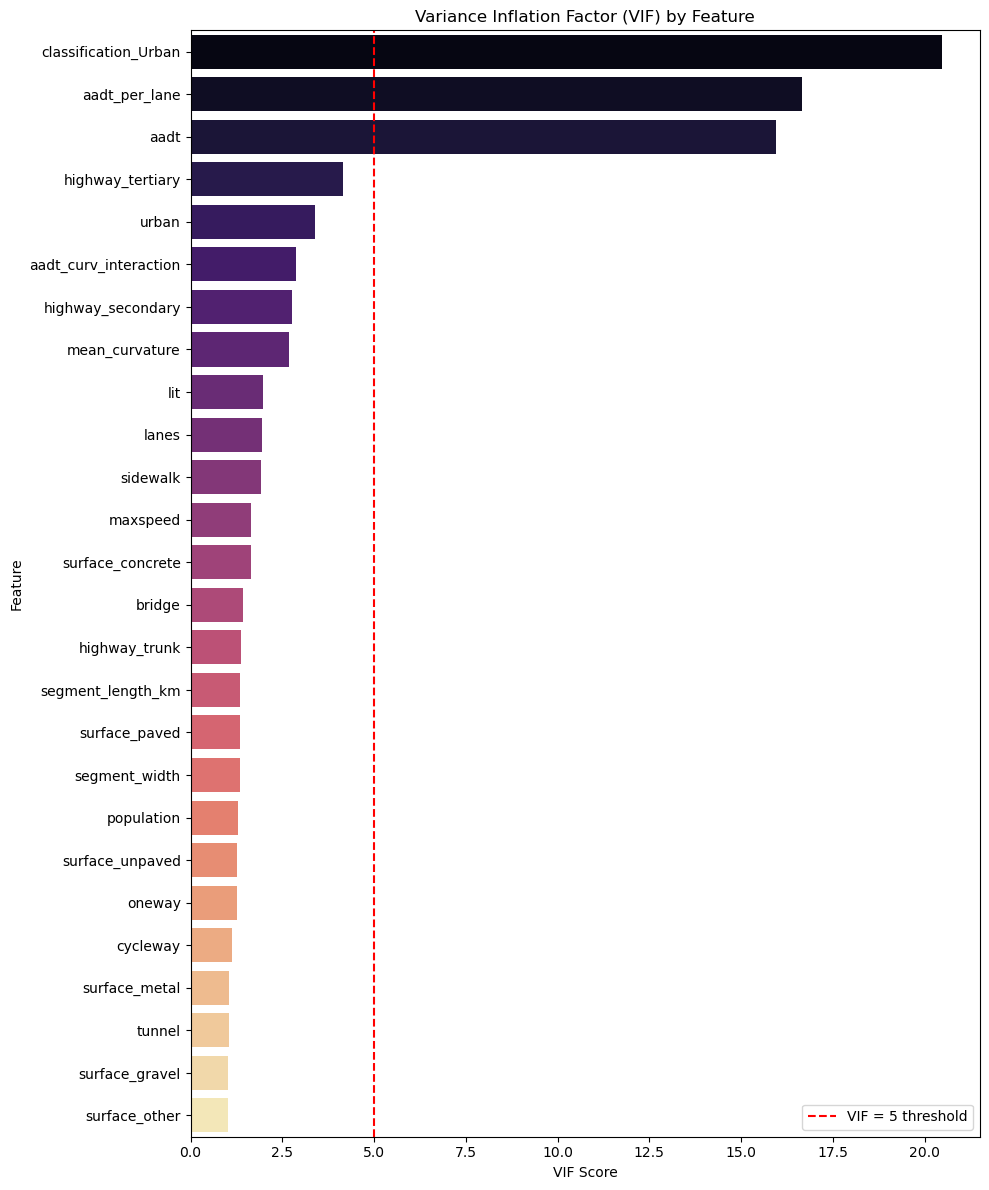

In [7]:
# === Step 7: Variance Threshold + VIF ===
vt = VarianceThreshold(0.0)
sup = vt.fit(X_tr_p).get_support()
X_tr_v = X_tr_p[:, sup]
X_te_v = X_te_p[:, sup]
fv = feat_names[sup]
vifs = []
with np.errstate(divide='ignore', invalid='ignore'):
    for i in range(X_tr_v.shape[1]):
        try: vifs.append(variance_inflation_factor(X_tr_v, i))
        except:  vifs.append(np.inf)
vif_df = pd.DataFrame({'feature': fv, 'VIF': vifs})
# === Common output ===
vif_df.to_csv(output_common/'vif_results.csv', index=False)
keep = vif_df[vif_df['VIF'] <= 5]['feature'].tolist()
must_include = ['maxspeed', 'maxspeed_sq', 'aadt_speed']
for f in must_include:
    if f in fv and f not in keep:
        keep.append(f)
keep_idx = [list(fv).index(f) for f in keep]
X_tr_f = X_tr_v[:, keep_idx]
X_te_f = X_te_v[:, keep_idx]

print("=== VIF Results ===")
print(vif_df)

print("\n=== Features Kept (VIF <= 5) ===")
print(keep)

print(f"\nNumber of features before VIF filtering: {len(fv)}")
print(f"Number of features after VIF filtering: {len(keep)}")

# Sort for better readability
vif_sorted = vif_df.sort_values('VIF', ascending=False)

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(data=vif_sorted, x='VIF', y='feature', palette='magma')
plt.axvline(x=5, color='red', linestyle='--', label='VIF = 5 threshold')
plt.title("Variance Inflation Factor (VIF) by Feature")
plt.xlabel("VIF Score")
plt.ylabel("Feature")
plt.legend()
plt.tight_layout()
plt.savefig(output_common / "vif_bar_plot.png")
plt.show()

In [8]:
print("=== VIF Results ===")
vif_df

=== VIF Results ===


,feature,VIF
0,lanes,1.934009
1,maxspeed,1.652624
2,segment_width,1.340985
3,mean_curvature,2.675316
4,aadt,15.962424
5,population,1.297833
6,segment_length_km,1.349252
7,aadt_curv_interaction,2.879208
8,aadt_per_lane,16.645696
9,bridge,1.440572


In [9]:
# ===  dataframe with kept features and their VIF scores ===
kept_vif_df = vif_df[vif_df['feature'].isin(keep)].copy()
kept_vif_df = kept_vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)

print("\n=== DataFrame of kept features after VIF filtering ===")
kept_vif_df


=== DataFrame of kept features after VIF filtering ===


,feature,VIF
0,highway_tertiary,4.143030
1,urban,3.384958
2,aadt_curv_interaction,2.879208
3,highway_secondary,2.753482
4,mean_curvature,2.675316
5,lit,1.986707
6,lanes,1.934009
7,sidewalk,1.933096
8,maxspeed,1.652624
9,surface_concrete,1.651244


In [10]:
# === 8. Train XGBoost ===
xgb_model = XGBRegressor(n_estimators=200, random_state=42, objective='reg:squarederror')
xgb_model.fit(X_tr_f, y_tr_rate)
with open(output_common / 'xgb_model.pkl', 'wb') as f: pickle.dump(xgb_model, f)
with open(output_common / 'preprocessor.pkl', 'wb') as f: pickle.dump(pre, f)
    
# === Predict on test set ===
predictions = xgb_model.predict(X_te_f)

# === Store predictions with true values and osm_id ===
pred_df = pd.DataFrame({
    'osm_id': X_test['osm_id'].values,
    'true_crash_rate': y_te_rate.values,
    'predicted_crash_rate': predictions
})


# === Save to CSV ===
pred_df.to_csv(output_common / "xgboost_predictions.csv", index=False)
pred_df

,osm_id,true_crash_rate,predicted_crash_rate
0,4357072,32.450291,33.951679
1,637270100,290.223280,303.516205
2,55654761,355.508896,333.809326
3,23212247,16.218733,15.814519
4,30614940,7.589498,7.729810
...,...,...,...
1087,1249813063,1800.749962,1797.519531
1088,28957492,224.114682,235.279984
1089,50425513,258.114926,259.036682
1090,157402554,55.277592,57.111511


C:\Users\joaqu\AppData\Local\Temp\ipykernel_18948\3851135262.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=irr_plot_df, x='IRR', y='feature', palette='viridis')


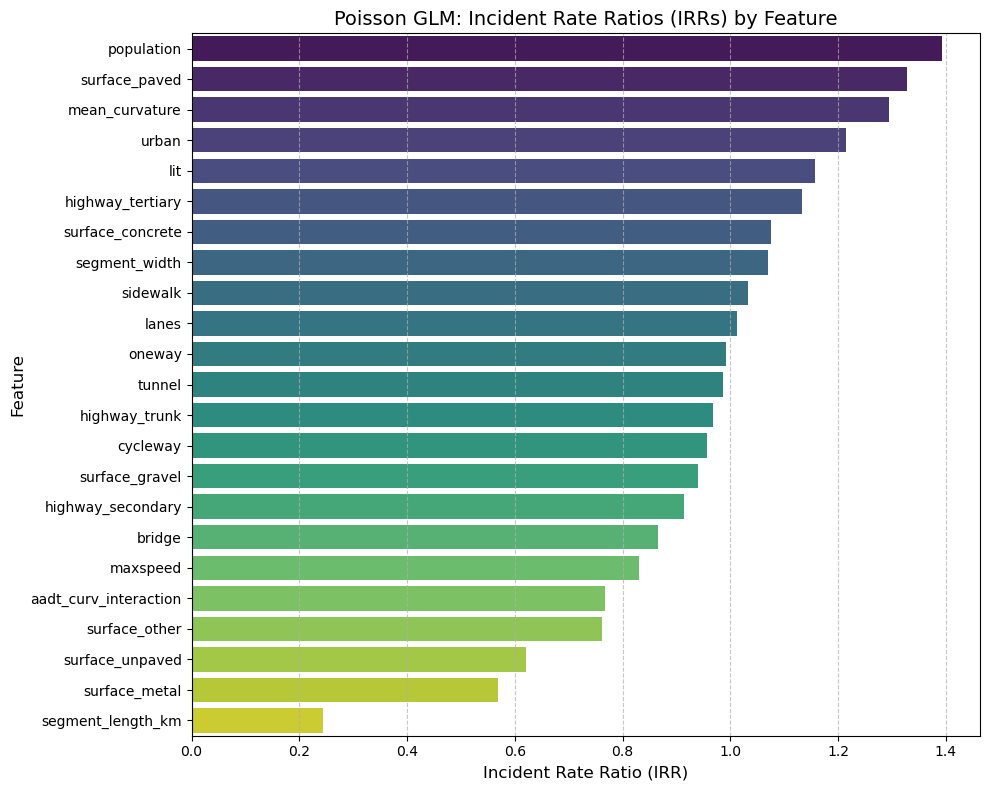

,feature,IRR
0,const,70.149835
1,lanes,1.012899
2,maxspeed,0.831091
3,segment_width,1.069057
4,mean_curvature,1.294937
5,population,1.393742
6,segment_length_km,0.243313
7,aadt_curv_interaction,0.768091
8,bridge,0.866450
9,tunnel,0.986482


In [11]:
# === 9. Train Poisson GLM ===
design_matrix = pd.DataFrame(X_tr_f, columns=keep, index=X_train.index)
design_with_constant = sm.add_constant(design_matrix, has_constant='add')
offset = np.log(X_train['segment_length_km'])

poisson_model = sm.GLM(
    y_tr_crash,
    design_with_constant,
    family=sm.families.Poisson(),
    offset=offset
).fit()

# Save Poisson model IRRs
irr_df = pd.DataFrame({
    'feature': poisson_model.params.index,
    'IRR': np.exp(poisson_model.params.values)
})
irr_df.to_csv(output_common / 'poisson_irrs.csv', index=False)

# Filter out the intercept (`const`) 
irr_plot_df = irr_df[irr_df['feature'] != 'const']

# Sort by IRR for better visualization (optional) ===
irr_plot_df = irr_plot_df.sort_values(by='IRR', ascending=False)

# Plot using seaborn ===
plt.figure(figsize=(10, 8))
sns.barplot(data=irr_plot_df, x='IRR', y='feature', palette='viridis')

# Plot styling ===
plt.title("Poisson GLM: Incident Rate Ratios (IRRs) by Feature", fontsize=14)
plt.xlabel("Incident Rate Ratio (IRR)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot ===
plt.savefig(output_common / "poisson_irr_plot.png", dpi=300)
plt.show()

irr_df

In [12]:
# === Step 10: Evaluate XGBoost ===
# Predict on test set
pred_xgb = xgb_model.predict(X_te_f)

# Compute metrics
mae = mean_absolute_error(y_te_rate, pred_xgb)
rmse = mean_squared_error(y_te_rate, pred_xgb, squared=False)
r2 = r2_score(y_te_rate, pred_xgb)

# Ensure output directory exists
output_common = Path("output_common")
output_common.mkdir(parents=True, exist_ok=True)

# Write metrics to file
with open(output_common / "metrics.txt", "w") as f:
    f.write(f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.2f}\n")



# Save Poisson metrics
with open(output_common / 'poisson_metrics.txt', 'w') as f:
    f.write(f"AIC: {poisson_model.aic:.2f}\n")
    f.write(f"Deviance: {poisson_model.deviance:.2f}\n")

# === Collect all metrics into a dictionary ===
metrics_data = {
    'metric': ['XGBoost MAE', 'XGBoost RMSE', 'XGBoost R²', 'Poisson AIC', 'Poisson Deviance'],
    'value': [mae, rmse, r2, poisson_model.aic, poisson_model.deviance]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df


C:\Users\joaqu\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,metric,value
0,XGBoost MAE,35.303783
1,XGBoost RMSE,406.495096
2,XGBoost R²,0.815364
3,Poisson AIC,605300.788149
4,Poisson Deviance,576657.498388


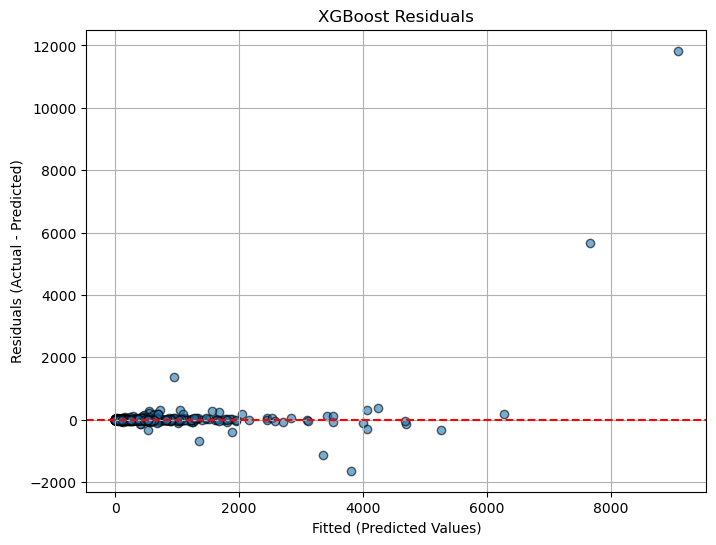

<Figure size 640x480 with 0 Axes>

In [12]:
# === Step 11: Diagnostic plots ===
# Residuals = actual - predicted
residuals = y_te_rate - pred_xgb
plt.figure(figsize=(8, 6))
plt.scatter(pred_xgb, residuals, alpha=0.6, edgecolor="k")
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted (Predicted Values)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("XGBoost Residuals")
plt.grid(True)
output_common.mkdir(parents=True, exist_ok=True)

# Save and show plot
plt.savefig(output_common / "xgb_residuals.png")
plt.show()
plt.clf()  




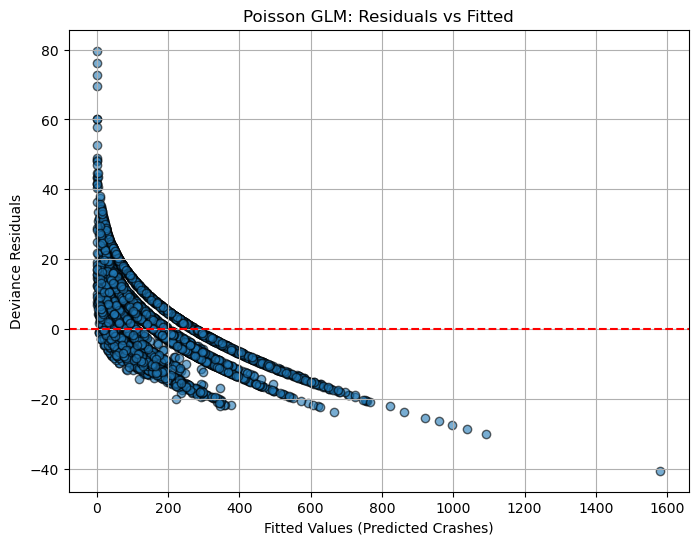

In [13]:
# === Poisson Residual Plot ===
residuals = poisson_model.resid_deviance  # Deviance residuals
fitted_values = poisson_model.fittedvalues  # Predicted (fitted) values

plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predicted Crashes)')
plt.ylabel('Deviance Residuals')
plt.title('Poisson GLM: Residuals vs Fitted')
plt.grid(True)

# Save and show
plt.savefig(output_common / 'poisson_residuals.png')
plt.show()


In [63]:
# === 12. Speed-based multi-target recommendations ===
reduction_percs = list(range(10, 110, 10))  # 10% to 100%
all_recs = {f"rf_rec_{p}pct": [] for p in reduction_percs}
cap_reasons = []

# Helper: Rule-based minimum speed cap and reason
def get_min_speed_cap_and_reason(row):
    if row['classification'] == 'Urban':
        is_narrow = row['segment_length_km'] < 0.5
        is_dense = row['population'] > 300_000
        is_curvy = row['mean_curvature'] > 0.01

        if is_narrow or is_dense or is_curvy:
            return 30, 'Urban - short/dense/curvy'
        else:
            return 50, 'Urban - major/long road'

    elif row['classification'] == 'Rural':
        is_straight = row['mean_curvature'] < 0.0015
        is_low_pop = row['population'] < 200_000
        is_long = row['segment_length_km'] > 5

        if is_straight and is_low_pop and is_long:
            return 60, 'Rural - long & straight'
        else:
            return 40, 'Rural - short or curved'

    return 30, 'Unclassified'

# Main loop for recommendations
for idx, row in X_test.iterrows():
    row_df = pd.DataFrame([row])
    try:
        static = pre.transform(row_df)[:, sup][:, keep_idx]
        base_pred = xgb_model.predict(static.reshape(1, -1))[0]
    except:
        for p in reduction_percs:
            all_recs[f"rf_rec_{p}pct"].append(np.nan)
        cap_reasons.append("Error in preprocessing")
        continue

    # Rule-based speed cap
    min_speed_cap, reason = get_min_speed_cap_and_reason(row)
    cap_reasons.append(reason)

    for p in reduction_percs:
        target = (1 - p / 100) * base_pred

        def f(s):
            tmp = row.copy()
            tmp['maxspeed'] = s
            tmp_df = pd.DataFrame([tmp])
            try:
                arr = pre.transform(tmp_df)[:, sup][:, keep_idx]
                pred = xgb_model.predict(arr.reshape(1, -1))[0]
                return pred - target
            except:
                return np.inf

        try:
            rec_speed = brentq(f, s_min, s_max)
            rec_speed = max(rec_speed, min_speed_cap)  # Enforce rule-based minimum
        except:
            rec_speed = np.nan

        all_recs[f"rf_rec_{p}pct"].append(rec_speed)

#  Compile Results 
rec_df = pd.DataFrame({
    'osm_id': X_test['osm_id'].values,
    'existing_maxspeed': X_test['maxspeed'].values,
    'highway': X_test['highway'].values,
    'classification': X_test['classification'].values,
    'mean_curvature': X_test['mean_curvature'].values,
    'population': X_test['population'].values,
    'segment_length_km': X_test['segment_length_km'].values,
    'cap_reason': cap_reasons
})

for p in reduction_percs:
    rec_df[f"rf_rec_{p}pct"] = all_recs[f"rf_rec_{p}pct"]

rec_df['has_valid_rec'] = rec_df[[f"rf_rec_{p}pct" for p in reduction_percs]].notna().any(axis=1)

# Save to CSV
rec_df.to_csv(output_speed / 'recommendations.csv', index=False)
print(" Speed-based recommendations saved.")


✅ Speed-based recommendations saved.


C:\Users\joaqu\AppData\Local\Temp\ipykernel_23724\238649146.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




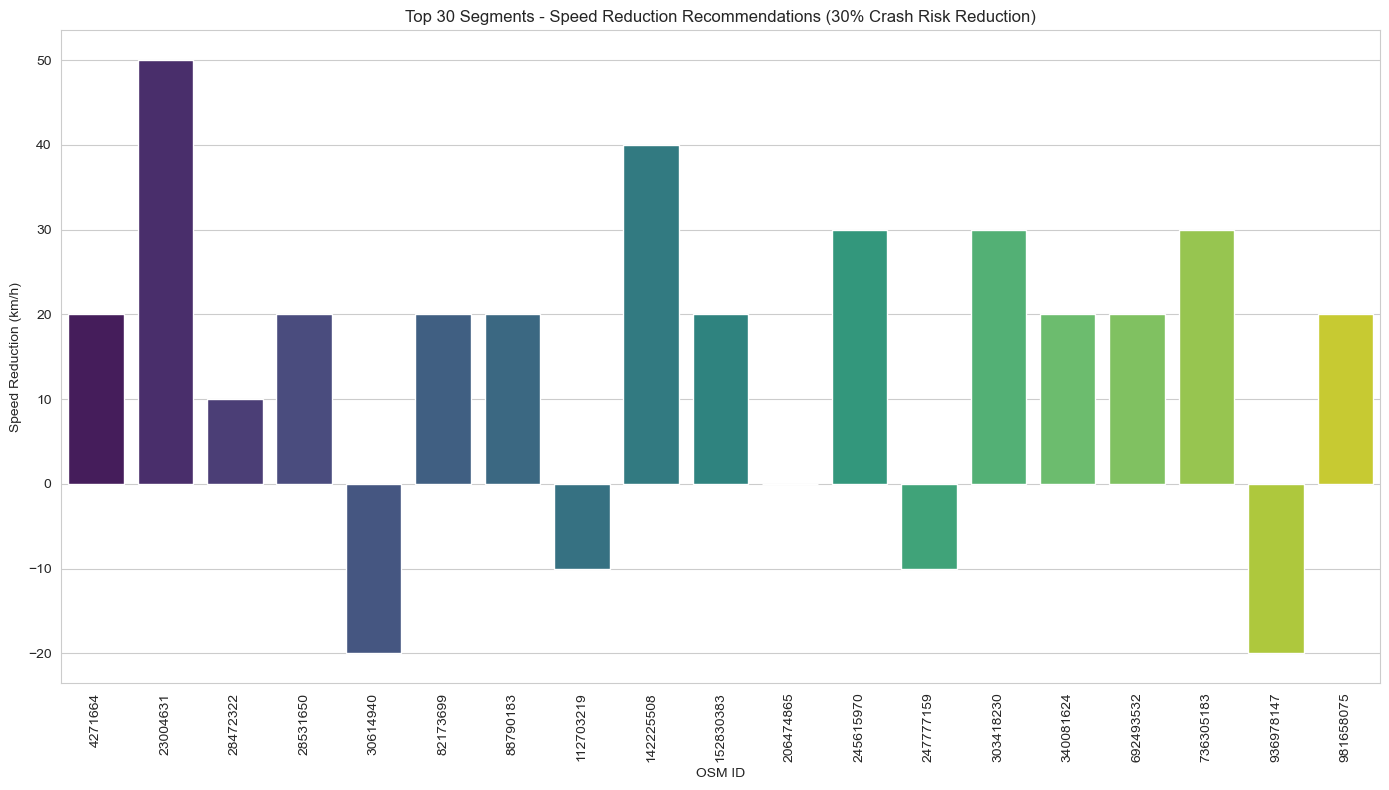

,osm_id,existing_maxspeed,recommended_speed,speed_reduction,mean_curvature,population,segment_length_km,highway,classification,cap_reason
0,23004631,80,30.000000,50.000000,0.003851,887399,20.463491,primary,Urban,Urban - short/dense/curvy
1,142225508,80,40.000000,40.000000,0.001549,207010,16.622851,primary,Rural,Rural - short or curved
2,736305183,60,30.000000,30.000000,0.000355,1503456,39.312153,primary,Urban,Urban - short/dense/curvy
3,245615970,60,30.000000,30.000000,0.000358,3325385,13.695205,secondary,Urban,Urban - short/dense/curvy
4,303418230,60,30.000000,30.000000,0.001129,703141,15.812311,tertiary,Urban,Urban - short/dense/curvy
5,82173699,80,60.000000,20.000000,0.001139,158218,19.743740,secondary,Rural,Rural - long & straight
6,692493532,60,40.000000,20.000000,0.003068,207010,3.636580,secondary,Rural,Rural - short or curved
7,4271664,60,40.000000,20.000000,0.003018,828655,28.030340,secondary,Rural,Rural - short or curved
8,981658075,60,40.000000,20.000000,0.000494,207010,0.546146,secondary,Rural,Rural - short or curved
9,152830383,60,40.000000,20.000000,0.005370,372910,16.630080,secondary,Urban,Urban - short/dense/curvy


In [65]:
# === Top 30 Segments with Largest Speed Reduction ===
reduction_pct = 30
col = f"rf_rec_{reduction_pct}pct"

# Load recommendation data
rec_df = pd.read_csv(output_speed / 'recommendations.csv')

# Filter for valid recommendations
rec_plot_df = rec_df[['osm_id', 'existing_maxspeed', col]].dropna().copy()
rec_plot_df['recommended_speed'] = rec_plot_df[col]
rec_plot_df['speed_reduction'] = rec_plot_df['existing_maxspeed'] - rec_plot_df['recommended_speed']

# Sort and take top 30
rec_plot_df = rec_plot_df.sort_values('speed_reduction', ascending=False).head(30)

# === Plot ===
plt.figure(figsize=(14, 8))
sns.barplot(data=rec_plot_df, x='osm_id', y='speed_reduction', palette='viridis')
plt.xticks(rotation=90)
plt.title(f"Top 30 Segments - Speed Reduction Recommendations ({reduction_pct}% Crash Risk Reduction)")
plt.xlabel("OSM ID")
plt.ylabel("Speed Reduction (km/h)")
plt.tight_layout()
plt.savefig(output_speed / f"top30_speed_reductions_{reduction_pct}pct.png", dpi=300)
plt.show()

# === Merge with relevant features for inspection ===
features_to_include = [
    'aadt', 'mean_curvature', 'population', 'segment_length_km',
    'highway', 'classification', 'cap_reason'
]
available_features = [f for f in features_to_include if f in rec_df.columns]

if available_features:
    rec_plot_df = rec_plot_df.merge(rec_df[['osm_id'] + available_features], on='osm_id', how='left')

# Reorder for clarity
ordered_cols = ['osm_id', 'existing_maxspeed', 'recommended_speed', 'speed_reduction'] + available_features
rec_plot_df = rec_plot_df[ordered_cols]

# Display final DataFrame
rec_plot_df


In [15]:
# === 13. Speed-based comparative analysis ===
for p in reduction_percs:
    rec_df[f"gap_{p}pct"] = rec_df[f"rf_rec_{p}pct"] - rec_df['existing_maxspeed']
gap_summaries=[]
for p in reduction_percs:
    temp=rec_df[['highway','classification',f'gap_{p}pct']]
    agg=temp.groupby(['highway','classification'])[f'gap_{p}pct'].agg(
        mean_gap='mean',median_gap='median',
        pct_within_5=lambda x:(x.abs()<=5).mean(),
        pct_within_10=lambda x:(x.abs()<=10).mean()
    ).reset_index()
    agg['reduction_pct']=p
    gap_summaries.append(agg)
gap_summary_all=pd.concat(gap_summaries,ignore_index=True)
# === Speed-based output ===
gap_summary_all.to_csv(output_speed/'gap_summary_all.csv',index=False)

# ===== POLICY-RELEVANT SENSITIVITY SCENARIOS =====
scenarios = {
    # AADT (traffic volume)
    'aadt_up_10': 1.10,         # +10% traffic
    'aadt_down_10': 0.90,       # -10% traffic
    'aadt_up_20': 1.20,         # +20% traffic
    'aadt_down_20': 0.80,       # -20% traffic

    # Curvature (road design)
    'curvature_up_10': 1.10,    # +10% more curvy
    'curvature_down_10': 0.90,  # -10% less curvy

    # Population (area densification)
    'population_up_10': 1.10,   # +10% pop
    'population_down_10': 0.90, # -10% pop

    # Lanes (infrastructure change, handled as int addition)
    'lanes_up_1': 1,            # +1 lane
    'lanes_down_1': -1,         # -1 lane

    # Speed limit (policy change)
    'maxspeed_up_10': 10,       # +10 kph
    'maxspeed_down_10': -10,    # -10 kph

    # Segment length (road works, splitting/merging)
    'segment_length_up_10': 1.10,
    'segment_length_down_10': 0.90,
}

In [16]:
# === 14. Speed-based sensitivity analysis ===
try:
    sa_list = []
    for name, factor in scenarios.items():
        tmp = X_test.copy()

        # Apply the scenario
        if 'aadt' in name:
            tmp['aadt'] *= factor
        elif 'curvature' in name:
            tmp['mean_curvature'] *= factor
        elif 'population' in name:
            tmp['population'] *= factor
        elif 'segment_length' in name:
            tmp['segment_length_km'] *= factor
        elif name == 'lanes_up_1':
            tmp['lanes'] = tmp['lanes'] + 1
        elif name == 'lanes_down_1':
            tmp['lanes'] = np.maximum(tmp['lanes'] - 1, 1)
        elif name == 'maxspeed_up_10':
            tmp['maxspeed'] += 10
        elif name == 'maxspeed_down_10':
            tmp['maxspeed'] = np.maximum(tmp['maxspeed'] - 10, 10)

        # Recompute engineered features
        tmp['aadt_curv_interaction'] = tmp['aadt'] * tmp['mean_curvature']
        tmp['aadt_lanes_interaction'] = tmp['aadt'] * tmp['lanes']
        tmp['aadt_length_interaction'] = tmp['aadt'] * tmp['segment_length_km']
        tmp['aadt_speed'] = tmp['aadt'] * tmp['maxspeed']
        tmp['aadt_pop_interaction'] = tmp['aadt'] * tmp['population']
        tmp['lanes_length_interaction'] = tmp['lanes'] * tmp['segment_length_km']
        tmp['lanes_speed_interaction'] = tmp['lanes'] * tmp['maxspeed']
        tmp['curv_lanes_interaction'] = tmp['mean_curvature'] * tmp['lanes']
        tmp['maxspeed_sq'] = tmp['maxspeed'] ** 2
        tmp['mean_curvature_sq'] = tmp['mean_curvature'] ** 2
        tmp['aadt_sq'] = tmp['aadt'] ** 2
        tmp['lanes_sq'] = tmp['lanes'] ** 2
        tmp['segment_length_sq'] = tmp['segment_length_km'] ** 2
        tmp['aadt_per_lane'] = tmp['aadt'] / tmp['lanes'].replace(0, np.nan)
        tmp['pop_density_per_length'] = tmp['population'] / tmp['segment_length_km'].replace(0, np.nan)
        tmp['aadt_per_length'] = tmp['aadt'] / tmp['segment_length_km'].replace(0, np.nan)
        tmp['urban'] = (tmp['classification'].str.lower().str.contains('urban')).astype(int)
        tmp['urban_high_aadt'] = ((tmp['urban'] == 1) & (tmp['aadt'] > tmp['aadt'].median())).astype(int)
        tmp['bridge_high_speed'] = ((tmp['bridge'] == 1) & (tmp['maxspeed'] > tmp['maxspeed'].median())).astype(int)
        tmp['tunnel_high_speed'] = ((tmp['tunnel'] == 1) & (tmp['maxspeed'] > tmp['maxspeed'].median())).astype(int)
        tmp['sidewalk_high_pop'] = ((tmp['sidewalk'] == 1) & (tmp['population'] > tmp['population'].median())).astype(int)
        tmp['oneway_high_speed'] = ((tmp['oneway'] == 1) & (tmp['maxspeed'] > tmp['maxspeed'].median())).astype(int)
        if 'crossings' in tmp.columns:
            tmp['crossings_per_km'] = tmp['crossings'] / tmp['segment_length_km'].replace(0, np.nan)

        # Prediction for current scenario
        static_all = pre.transform(tmp)[:, sup][:, keep_idx]
        base_all = xgb_model.predict(static_all)

        for p in reduction_percs:
            target = 0.01 * (100 - p) * base_all
            recs = []
            for row, t in zip(tmp.to_dict('records'), target):
                def f(s):
                    trow = row.copy()
                    trow['maxspeed'] = s
                    arr = pre.transform(pd.DataFrame([trow]))[:, sup][:, keep_idx]
                    return xgb_model.predict(arr.reshape(1, -1))[0] - t
                try:
                    recs.append(brentq(f, s_min, s_max))
                except:
                    recs.append(np.nan)

            sa_list.append(pd.DataFrame({
                'osm_id': X_test['osm_id'],
                'scenario': name,
                'reduction_pct': p,
                'rec': recs
            }))

    sa_df = pd.concat(sa_list, ignore_index=True)
    sa_df.to_csv(output_speed / 'sensitivity_analysis_all.csv', index=False)

except Exception as e:
    print("Sensitivity analysis not run:", e)


Sensitivity analysis not run: [Errno 13] Permission denied: 'output_speed_based\\sensitivity_analysis_all.csv'


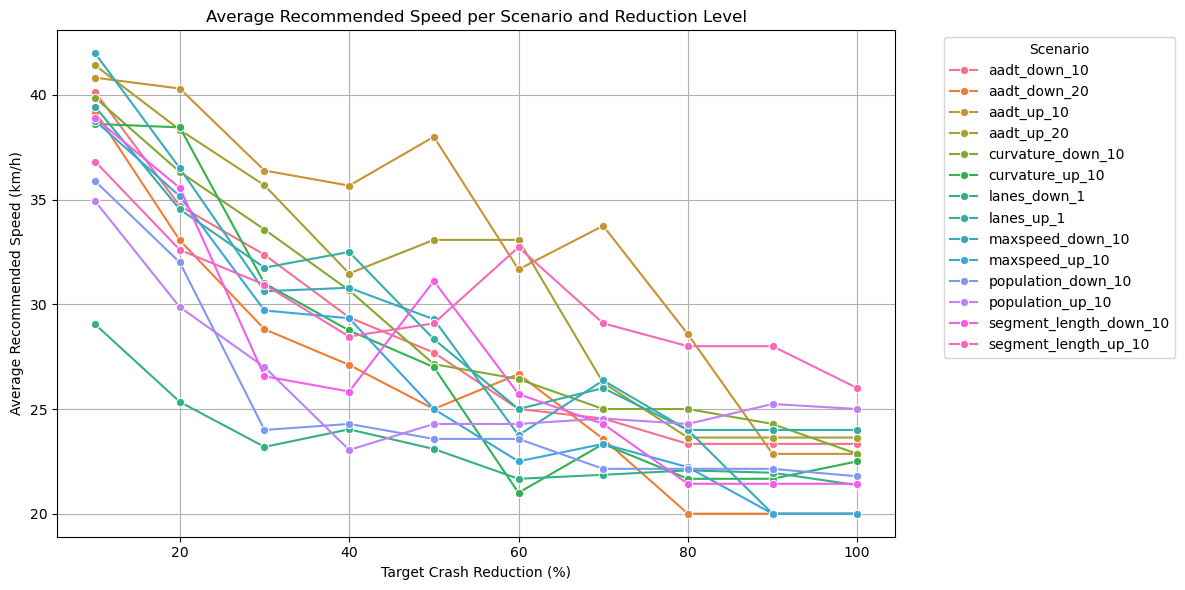

In [34]:
#Plot speed recommendations  across scenarios and reduction targets 
sa_df = pd.read_csv(output_speed / 'sensitivity_analysis_all.csv')

# Remove NaN recommendations (failed optimizations)
sa_df_clean = sa_df.dropna(subset=['rec'])

# Compute average recommended speed per scenario and reduction level
summary = sa_df_clean.groupby(['scenario', 'reduction_pct'])['rec'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary, x='reduction_pct', y='rec', hue='scenario', marker='o')

plt.title('Average Recommended Speed per Scenario and Reduction Level')
plt.xlabel('Target Crash Reduction (%)')
plt.ylabel('Average Recommended Speed (km/h)')
plt.grid(True)
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save plot
plt.savefig(output_speed / 'sensitivity_analysis_plot.png', dpi=300)
plt.show()

In [24]:
# === Step 15: Save models ===
with open(output_common / "xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
with open(output_common / "poisson_model.pkl", "wb") as f:
    pickle.dump(poisson_model, f)


In [30]:
# === 16. Other-features-based recommendations and risk scoring ===

# Identify top 3 non-speed features
top_non_speed_features = irr_df[
    (~irr_df['feature'].str.contains('maxspeed')) &
    (irr_df['feature'] != 'const')
]['feature'].head(3).tolist()

print("Top non-speed features:", top_non_speed_features)

# Risk scoring and flagging
scaler = MinMaxScaler()
X_test_scaled = X_test.copy()

# Normalize selected top non-speed features
X_test_scaled[[f + '_norm' for f in top_non_speed_features]] = scaler.fit_transform(
    X_test[top_non_speed_features]
)

# Compute composite risk score
X_test_scaled['composite_risk'] = X_test_scaled[[f + '_norm' for f in top_non_speed_features]].sum(axis=1)

# Flag top 10% segments as priority
X_test_scaled['priority'] = X_test_scaled['composite_risk'] > X_test_scaled['composite_risk'].quantile(0.9)

# Export segments with highest composite risk (non-speed-based)
X_test_scaled[['osm_id'] + top_non_speed_features + ['composite_risk', 'priority']].to_csv(
    output_other / 'high_risk_segments.csv', index=False
)

# Also create recommendations as text based on which feature is highest
def get_other_recommendation(row):
    values = [row[f + '_norm'] for f in top_non_speed_features]
    best = np.argmax(values)
    return f"Intervene due to high {top_non_speed_features[best]}"

X_test_scaled['other_feature_recommendation'] = X_test_scaled.apply(get_other_recommendation, axis=1)

# Export recommendations
X_test_scaled[['osm_id', 'composite_risk', 'priority', 'other_feature_recommendation']].to_csv(
    output_other / 'recommendations_by_other_features.csv', index=False
)


Top non-speed features: ['lanes', 'segment_width', 'mean_curvature']


C:\Users\joaqu\AppData\Local\Temp\ipykernel_23724\1022559230.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


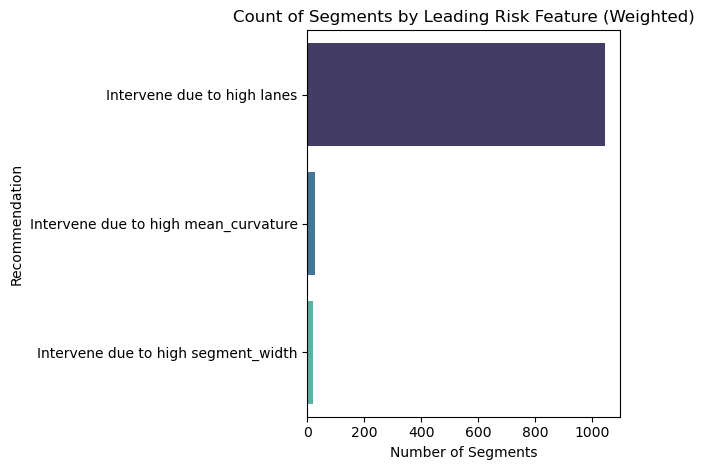

In [31]:
# Top non-speed risk feature
sns.countplot(
    y='other_feature_recommendation',
    data=X_test_scaled,
    order=X_test_scaled['other_feature_recommendation'].value_counts().index,
    palette='mako'
)
plt.title("Count of Segments by Leading Risk Feature (Weighted)")
plt.xlabel("Number of Segments")
plt.ylabel("Recommendation")
plt.tight_layout()
plt.show()


In [66]:
print("Done")

Done
